In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not available. Switching to CPU.")

Default GPU Device: /device:GPU:0


In [ ]:
print(tf.__version__)


2.15.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pandas as pd
import google.colab.drive as drive
import os, requests, cv2, random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
import os
root_dir = "/content/drive/My Drive/"
project_folder = "Colab Notebooks/Project_folder/"
def create_and_set_working_directory(project_folder):
 if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
os.chdir(root_dir + project_folder)
!touch 'new_file_test.txt'
print('working directory' + root_dir + project_folder + \
        "empty text file created.")

create_and_set_working_directory(project_folder)

working directory/content/drive/My Drive/Colab Notebooks/Project_folder/empty text file created.


In [ ]:
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs =30

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
image_directory = '/content/drive/My Drive/Colab Notebooks/Project_folder/PlantVillage'
if not os.path.exists(image_directory):
    raise ValueError(f"Image directory not found: {image_directory}")

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
image_directory,
batch_size=Batch_Size,
image_size=(Image_Size,Image_Size),
shuffle=True)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                               shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                validation_split=0.3)# specifying the validation split inside the function

test_datagen = ImageDataGenerator(rescale=1/255.0,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

In [ ]:
train_gen = train_datagen.flow_from_directory(
                                image_directory,
                                target_size=(224, 224),
                                batch_size=32,
                                shuffle=True,
                                class_mode='categorical',
                                subset='training')

Found 1507 images belonging to 3 classes.


In [ ]:
val_gen = train_datagen.flow_from_directory(
                                image_directory,
                                target_size=(224,224),
                                batch_size=32,
                                shuffle=True,
                                class_mode='categorical',
                                subset='validation')

Found 645 images belonging to 3 classes.


In [ ]:
test_gen = test_datagen.flow_from_directory(
        image_directory,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle = False) #shuffle will not affect the accuracy of the model, but will affect the computation of some metrics that depend on the order of the samples

Found 2152 images belonging to 3 classes.


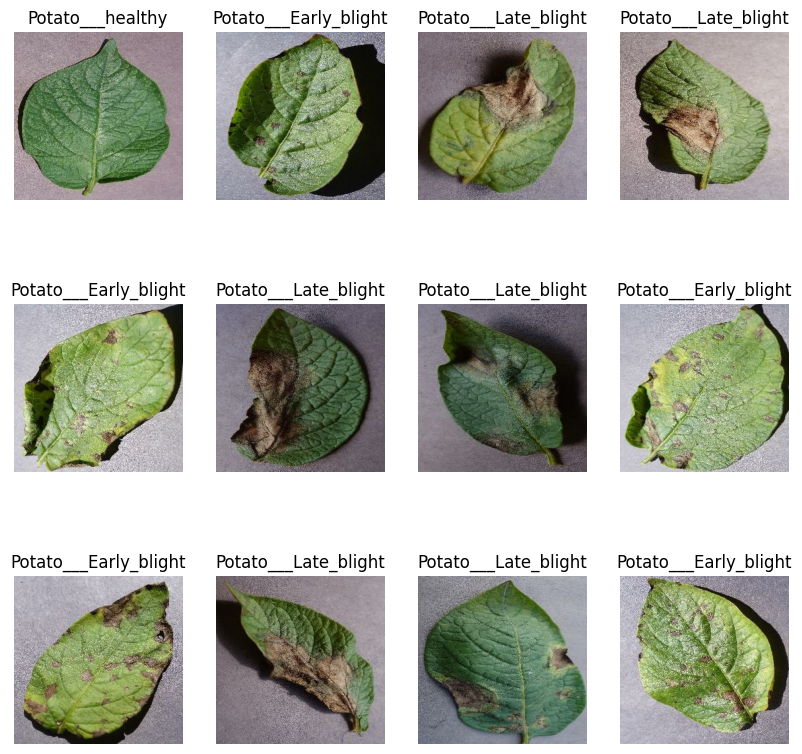

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [ ]:
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [ ]:

train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [ ]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
val_ds = test_ds.skip(6)
len(val_ds)

8

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1

        ds_size=len(ds)#68
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        train_size=int(train_split*ds_size)#0.8*68=54
        val_size=int(val_split*ds_size)#0.1*68=6
        train_ds = ds.take(train_size) #54
        val_ds = ds.skip(train_size).take(val_size)#it will skip 54 and take 6
        return train_ds, val_ds, ds.skip(train_size).skip(val_size)

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)


6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.63529414 0.58431375 0.6117647 ]
  [0.6431373  0.5921569  0.61960787]
  [0.5882353  0.5372549  0.5647059 ]
  ...
  [0.56078434 0.49803922 0.5411765 ]
  [0.5686275  0.5058824  0.54901963]
  [0.5568628  0.49411765 0.5372549 ]]

 [[0.5882353  0.5372549  0.5647059 ]
  [0.60784316 0.5568628  0.58431375]
  [0.5686275  0.5176471  0.54509807]
  ...
  [0.5647059  0.5019608  0.54509807]
  [0.5647059  0.5019608  0.54509807]
  [0.5529412  0.49019608 0.53333336]]

 [[0.5921569  0.5411765  0.5686275 ]
  [0.61960787 0.5686275  0.59607846]
  [0.6117647  0.56078434 0.5882353 ]
  ...
  [0.5686275  0.5058824  0.54901963]
  [0.5647059  0.5019608  0.54509807]
  [0.5529412  0.49019608 0.53333336]]

 ...

 [[0.64705884 0.6039216  0.63529414]
  [0.7411765  0.69803923 0.7294118 ]
  [0.7294118  0.6862745  0.7176471 ]
  ...
  [0.6        0.54901963 0.5882353 ]
  [0.60784316 0.5568628  0.59607846]
  [0.61960787 0.5686275  0.60784316]]

 [[0.5568628  0.5137255  0.54509807]
  [0.5882353  0.54509807 0.5764706 ]


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_Size,Image_Size),
  layers.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
cnn = models.Sequential()
resize_and_rescale,
data_augmentation,
cnn.add(layers.Conv2D (32, kernel_size = (3,3), activation='relu', input_shape = [224, 224,3])),
cnn.add(layers.MaxPooling2D(pool_size = (2, 2))),

cnn.add(layers.Conv2D(64, (3,3), activation='relu')),
cnn.add(layers. MaxPooling2D((2, 2))),

cnn.add(layers.Conv2D (64, (3,3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers.Conv2D(64, (3, 3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers. Conv2D (64, (3, 3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers.Conv2D(64, (3, 3), activation='relu')),
cnn.add(layers.MaxPooling2D((2, 2))),

cnn.add(layers.Flatten()),

cnn.add(layers.Dense(64,activation='relu'))

cnn.add(layers.Dense(3,activation='softmax'))

In [ ]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
cnn.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 20,
                   verbose = 1,
                   restore_best_weights = True)

In [ ]:
print(cnn.output_shape)

(None, 3)


In [ ]:
history = cnn.fit(x = train_gen,
                    callbacks = [es],
                    epochs = 50,
                    validation_data = val_gen)

Epoch 1/50
48/48 [==============================] - 290s 6s/step - loss: 0.9448 - accuracy: 0.4698 - val_loss: 0.8876 - val_accuracy: 0.5101
Epoch 2/50
48/48 [==============================] - 43s 897ms/step - loss: 0.8855 - accuracy: 0.4711 - val_loss: 0.8762 - val_accuracy: 0.4667
Epoch 3/50
48/48 [==============================] - 40s 834ms/step - loss: 0.8700 - accuracy: 0.5017 - val_loss: 0.8487 - val_accuracy: 0.5938
Epoch 4/50
48/48 [==============================] - 33s 701ms/step - loss: 0.8202 - accuracy: 0.6324 - val_loss: 0.7707 - val_accuracy: 0.6248
Epoch 5/50
48/48 [==============================] - 42s 885ms/step - loss: 0.7146 - accuracy: 0.7007 - val_loss: 0.6536 - val_accuracy: 0.7349
Epoch 6/50
48/48 [==============================] - 34s 722ms/step - loss: 0.6402 - accuracy: 0.7452 - val_loss: 0.6101 - val_accuracy: 0.7690
Epoch 7/50
48/48 [==============================] - 35s 718ms/step - loss: 0.5803 - accuracy: 0.7704 - val_loss: 0.5744 - val_accuracy: 0.7674
E

In [ ]:
scores = cnn.evaluate(test_gen)

In [ ]:
scores

[0.10206384211778641, 0.9605018496513367]

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

5

In [ ]:
history.history['loss'][:5]

[0.33437398076057434,
 0.3262557089328766,
 0.2624645233154297,
 0.21677860617637634,
 0.221660777926445]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

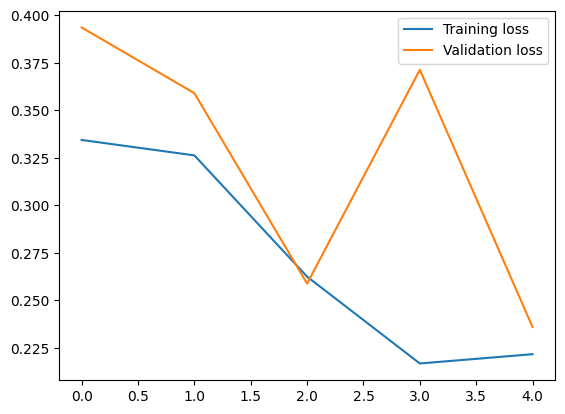

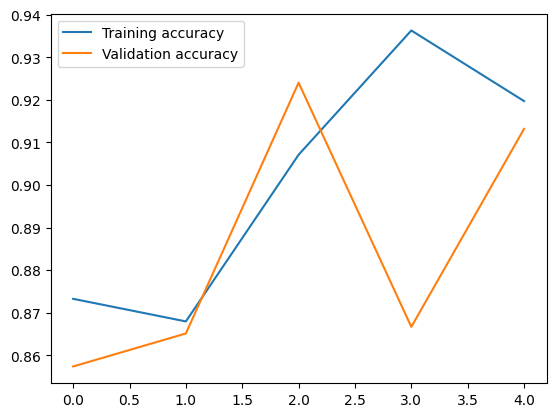

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

In [ ]:
cnn.save('/content/drive/My Drive/my_model.keras')


In [ ]:
test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)

<ipython-input-54-c676ae2200e0>:1: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_gen.samples / test_gen.batch_size)


In [ ]:

predictions = cnn.predict(test_gen, steps=test_steps_per_epoch)

68/68 [==============================] - 34s 502ms/step


In [ ]:
predictions[1]

array([9.7488731e-01, 2.5108892e-02, 3.8208982e-06], dtype=float32)

In [ ]:
predicted_classes = np.argmax(predictions,axis=1)

In [ ]:

true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

In [ ]:
confusion_matrix = confusion_matrix(test_gen.classes, predicted_classes)
print(confusion_matrix)

[[945  55   0]
 [ 44 952   4]
 [  1  43 108]]


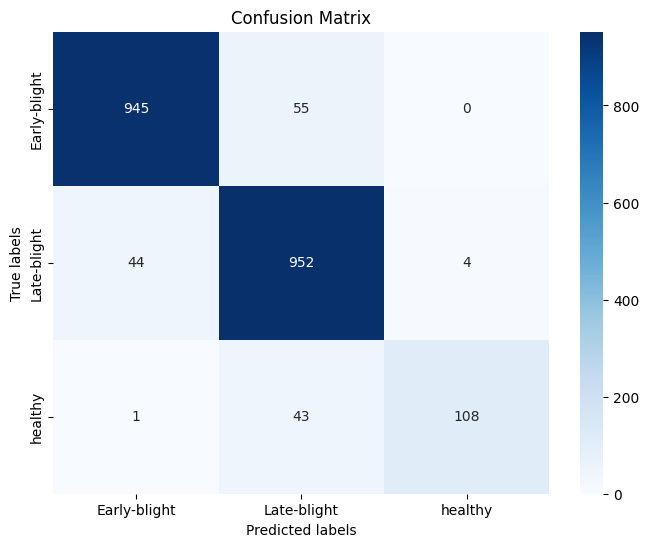

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Early-blight','Late-blight','healthy'], yticklabels=['Early-blight','Late-blight','healthy'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                       precision    recall  f1-score   support

Potato___Early_blight       0.95      0.94      0.95      1000
 Potato___Late_blight       0.91      0.95      0.93      1000
     Potato___healthy       0.96      0.71      0.82       152

             accuracy                           0.93      2152
            macro avg       0.94      0.87      0.90      2152
         weighted avg       0.93      0.93      0.93      2152



In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
from tensorflow.keras.models import load_model
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import time


model = load_model('cnn.h5')


disease_labels = {
    0: 'Late Blight',
    1: 'Early Blight',
    2: 'Healthy Leaf'
}


def predict_disease(image):

    image_resized = cv2.resize(image, (224, 224))


    image_preprocessed = image_resized / 255.0
    image_expanded = np.expand_dims(image_preprocessed, axis=0)


    predictions = model.predict(image_expanded)
    predicted_class = np.argmax(predictions)

    return disease_labels[predicted_class], predictions[0][predicted_class]


def main():

    st.set_page_config(
        page_title="Leaf Disease Detector",
        page_icon="🍃",
        layout="wide",
        initial_sidebar_state="collapsed"
    )


    st.markdown(
        """
        <style>
            .main-container {
                background-color: #b5e48c;
                display: flex;
                align-items: center;
                justify-content: center;
                flex-direction: column;
            }
            .content-container {
                max-width: 800px;
                padding: 2rem;
                background-color: #ffffff;
                border-radius: 10px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
            }
            .logo-container {
                display: flex;
                align-items: center;
                justify-content: center;
                margin-bottom: 2rem;
            }
            .logo-text {
                font-size: 2.5rem;
                color: #4c8c4a;
                font-weight: bold;
                text-transform: uppercase;
                letter-spacing: 0.1rem;
                margin-left: 1rem;
            }
            .footer {
                margin-top: 2rem;
                font-size: 1.2rem;
                text-align: center;
            }
        </style>
        """,
        unsafe_allow_html=True
    )

    st.markdown("<div class='main-container'>", unsafe_allow_html=True)

    st.markdown("<div class='logo-container'>", unsafe_allow_html=True)
    st.image("/content/photo-1533119408463-b0f487583ff6.avif", width=100)
    st.markdown("<h1 class='logo-text'>Leaf Disease Detector</h1>", unsafe_allow_html=True)
    st.markdown("</div>", unsafe_allow_html=True)

    st.markdown("<div class='content-container'>", unsafe_allow_html=True)
    st.write(
        "Welcome to the Leaf Disease Detector! Upload an image of a leaf to predict the type of disease affecting it."
    )


    uploaded_file = st.file_uploader("Upload an image of a leaf", type=['jpg', 'jpeg', 'png'])

    if uploaded_file is not None:

        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image', use_column_width=True)


        with st.spinner('Predicting...'):
            time.sleep(2)
            disease, confidence = predict_disease(np.array(image))


        st.success(f"Predicted Disease: {disease}, Confidence: {confidence:.2f}")


        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(image)
        ax1.set_title("Original Image")
        ax1.axis('off')
        ax2.imshow(image)
        ax2.set_title(f"Predicted: {disease}")
        ax2.axis('off')
        st.pyplot(fig)

    st.markdown("</div>", unsafe_allow_html=True)

    st.markdown("<div class='footer'>", unsafe_allow_html=True)
    st.write("Made with 🍀 Manya Jain")
    st.markdown("</div>", unsafe_allow_html=True)

    st.markdown("</div>", unsafe_allow_html=True)

if __name__ == "__main__":
    main()


Overwriting app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/drive/MyDrive/Colab Notebooks/Project_folder/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/drive/MyDrive/Colab Notebooks/Project_folder/package.json'
npm WARN Project_folder No description
npm WARN Project_folder No repository field.
npm WARN Project_folder No README data
npm WARN Project_folder No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 10.203s

3 packages are looking for funding
  run `npm fund` for details

found 2 moderate severity vulnerabilities
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
!streamlit run app.py &>/content/logs.txt &


In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 34.32.252.193


In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 3.586s
your url is: https://olive-peaches-shout.loca.lt
